Блок кода для визуализации процесса обучения модели:

In [3]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  def display(self,groups = None):
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

# Задание 1. Создание полносвязной сети

1. Создайте двухслойную* полносвязную нейронную сеть средствами Pytorch.
2. Обучите ее на CIFAR10.
3. Посмотрите график зависимости loss и accuracy от эпохи в процессе обучения.

Для создания полносвязанных слоев используйте класс [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)

*Рекомендуется использовать скрытый слой со 128 нейронами.

Загрузим датасет с помощью средств PyTorch.

In [2]:
import torch
import torch.nn as nn
from tqdm import trange
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

Что бы результаты экспериментов воспроизводились зафиксируем seed's

In [4]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In [5]:
from torch.utils.data import random_split
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


trainset, valset, _  = random_split(dataset, [12000, 3000, 35000])


100%|██████████| 170498071/170498071 [00:03<00:00, 46541607.89it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


Опишите структуру сети: полносвязные слои + [функции активации](https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity) на ваш выбор.

Здесь **не** используйте `nn.Sequential`, чтобы была возможность изменять функцию активации в существующем экземпляре класса (потребуется для 5 задания).




In [6]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.first = nn.Linear(3 * 32 * 32, 64)
        self.second = nn.Linear(64, 10)
        self.func = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.first(x)
        x = self.func(x)
        y = self.second(x)
        return y

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FCNet().to(device)
model

FCNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (first): Linear(in_features=3072, out_features=64, bias=True)
  (second): Linear(in_features=64, out_features=10, bias=True)
  (func): ReLU()
)

**Блок обучения. Можно использовать без изменений.**

Пример с более подробным [описанием блока обучения в документации Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)


Обратите внимание на то, что в PyTorch моделях не используется метод fit, как в sklearn. Код, отвечающий за обучение, пишется отдельно.

Определим batch_size и создадим два DataLoader'a для обучающей и тестовой части

In [8]:
batch_size = 256

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подсчёт точности:

In [9]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs)
        loss += criterion(pred, labels)
        correct += get_correct_count(pred,labels)
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

**Основной цикл обучения.**

Определим его как отдельную функцию.


In [10]:
def train(model, criterion, optimizer, num_epochs=10, tag="cifar10"):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        for imgs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            correct += get_correct_count(outputs,labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            ep_loss += loss.item()
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_loader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val = calaculate_accuracy(model,val_loader,criterion)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)

        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    return pp

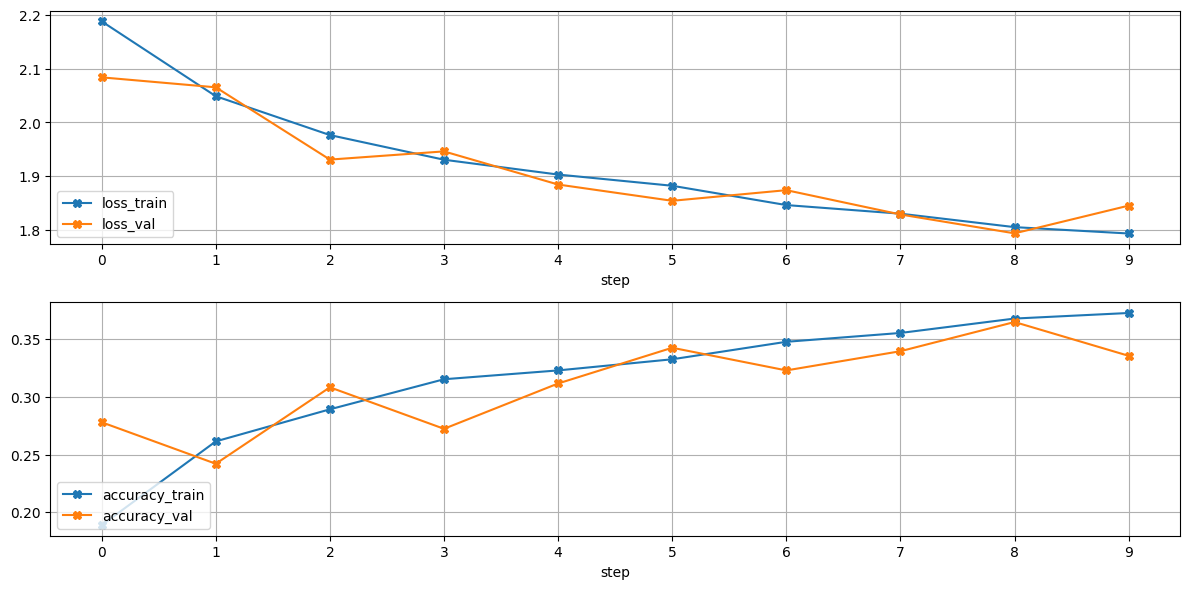

In [ ]:
model = FCNet()  # Create model instance
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10)

Оценим точность на тестовом наборе данных

In [ ]:
test_accuracy, _ = calaculate_accuracy(model.eval(), test_loader,criterion)
print(f"Accuracy on TEST {test_accuracy:.2f}")

Accuracy on TEST 0.35


## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX05/result_2_task_ex05.png" width="600">

# Задание 2. Нормализация данных

Стандартизируйте данные.

* Подсчитайте среднее значение и стандартное отклонение для каждого из 3-х цветовых каналов
 * Сделайте это с помощью встроенных в torch или numpy функций
* Нормализуйте данные с использованием этих параметров (используйте трансформацию Normalize)
* Оцените влияние нормировки данных на точность обучения. (Сравните результаты обучения на сырых данных и на стандартизованных)

In [11]:
print(dataset.data.shape)
tensor0 = torch.tensor(dataset.data).permute(3, 2, 1, 0)
tensor0.size()

(50000, 32, 32, 3)


torch.Size([3, 32, 32, 50000])

In [12]:
tensor0

tensor([[[[ 59, 154, 255,  ...,  35, 189, 229],
          [ 16, 140, 255,  ...,  57, 194, 222],
          [ 25, 140, 255,  ...,  98, 208, 213],
          ...,
          [208, 175, 113,  ...,  73, 207, 150],
          [180, 165, 111,  ...,  61, 198, 137],
          [177, 163, 106,  ...,  44, 198, 122]],

         [[ 43, 126, 253,  ...,  40, 186, 236],
          [  0, 145, 255,  ...,  44, 191, 239],
          [ 16, 139, 254,  ...,  64, 205, 234],
          ...,
          [201, 156, 111,  ...,  53, 203, 140],
          [173, 156, 104,  ...,  55, 189, 130],
          [168, 158,  99,  ...,  46, 189, 118]],

         [[ 50, 105, 253,  ...,  42, 185, 234],
          [ 18, 125, 255,  ...,  50, 190, 233],
          [ 49, 115, 254,  ...,  69, 204, 231],
          ...,
          [198, 154, 105,  ...,  54, 203, 132],
          [186, 159,  99,  ...,  57, 180, 125],
          [179, 163,  95,  ...,  49, 178, 120]],

         ...,

         [[158,  91, 253,  ...,  99, 175, 217],
          [123,  96, 2

In [13]:
mean = []
std = []
for val in tensor0:
  mean.append(torch.mean(val.double())/255)
  std.append(torch.std(val.double())/255)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: [tensor(0.4914, dtype=torch.float64), tensor(0.4822, dtype=torch.float64), tensor(0.4465, dtype=torch.float64)]
Std: [tensor(0.2470, dtype=torch.float64), tensor(0.2435, dtype=torch.float64), tensor(0.2616, dtype=torch.float64)]


In [14]:
from torchvision.transforms import Normalize
from torchvision import transforms

tensor_norm = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean), (std))])
dataset.transform = tensor_norm
testset.transform = tensor_norm

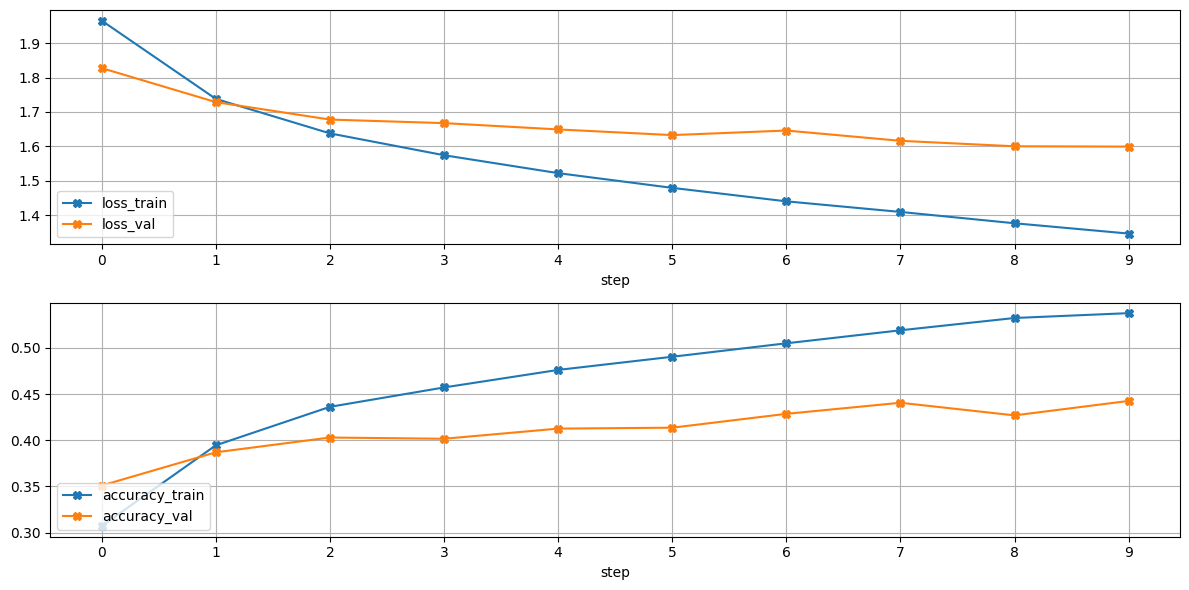

In [ ]:
model = FCNet()  # Create model instance
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model, criterion, optimizer, num_epochs=10)

In [ ]:
test_accuracy, _ = calaculate_accuracy(model.eval(), test_loader,criterion)
print(f"Accuracy on TEST {test_accuracy:.2f}")

Accuracy on TEST 0.45


Точность улучшилась

## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX05/result_3_task_ex05.png" width="600">

# Задание 3. Влияние функций активации

* Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

* Используйте три функции:

 * [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
 * [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
 * [ReLU](https://pytorch.org/docs/stable/nn.functional.html#relu)
* Постройте графики потерь loss для разных функций активации в одних осях.

* Можете модифировать конструктор класса сети, чтобы была возможность передать туда желаемую функцию активации.

In [15]:
mas_func = [nn.Sigmoid(), nn.GELU(), nn.ReLU()]
mas_pp = []

class FCNet(nn.Module):
    def __init__(self, func_):
        super().__init__()
        self.flatten = nn.Flatten()
        self.first = nn.Linear(3 * 32 * 32, 64)
        self.second = nn.Linear(64, 10)
        self.func = func_

    def forward(self, x):
        x = self.flatten(x)
        x = self.first(x)
        x = self.func(x)
        y = self.second(x)
        return y

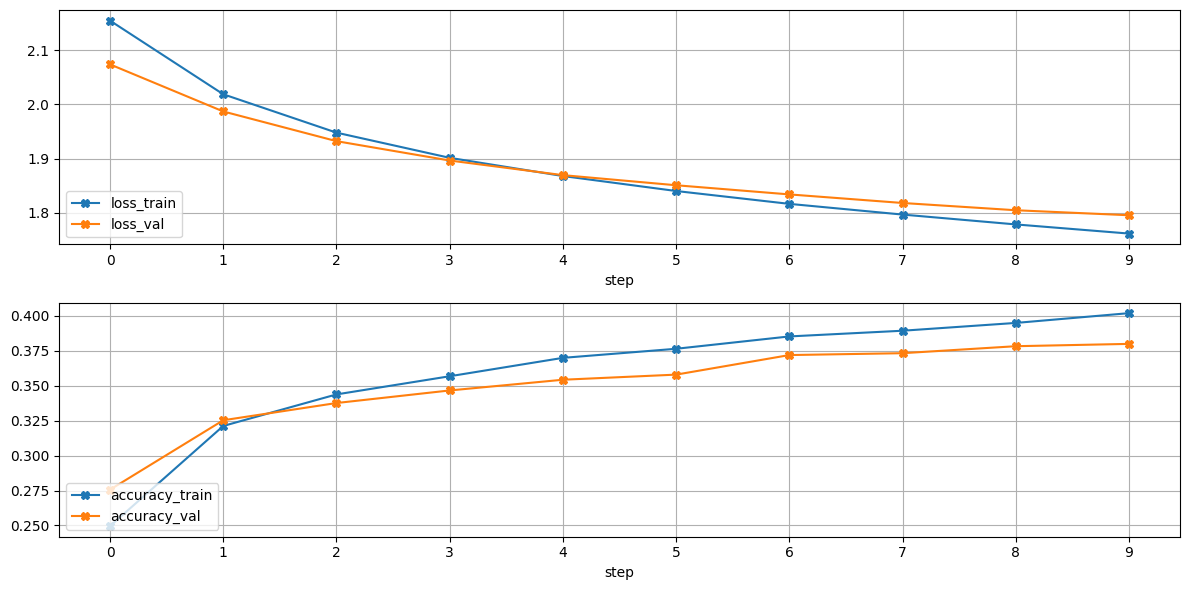

In [ ]:
print('Sigmoid')
model0 = FCNet(mas_func[0])  # Create model instance
model0.train()
optimizer = torch.optim.SGD(model0.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model0, criterion, optimizer, num_epochs=10)
mas_pp.append(pp)

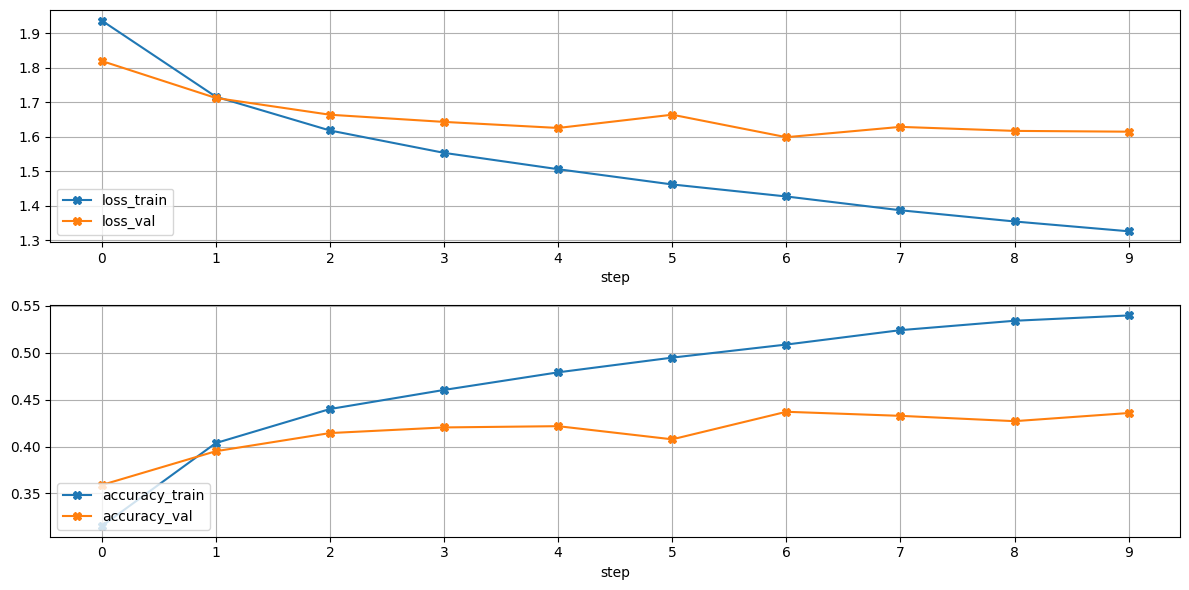

In [ ]:
print('GELU')
model1 = FCNet(mas_func[1])  # Create model instance
model1.train()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model1, criterion, optimizer, num_epochs=10)
mas_pp.append(pp)

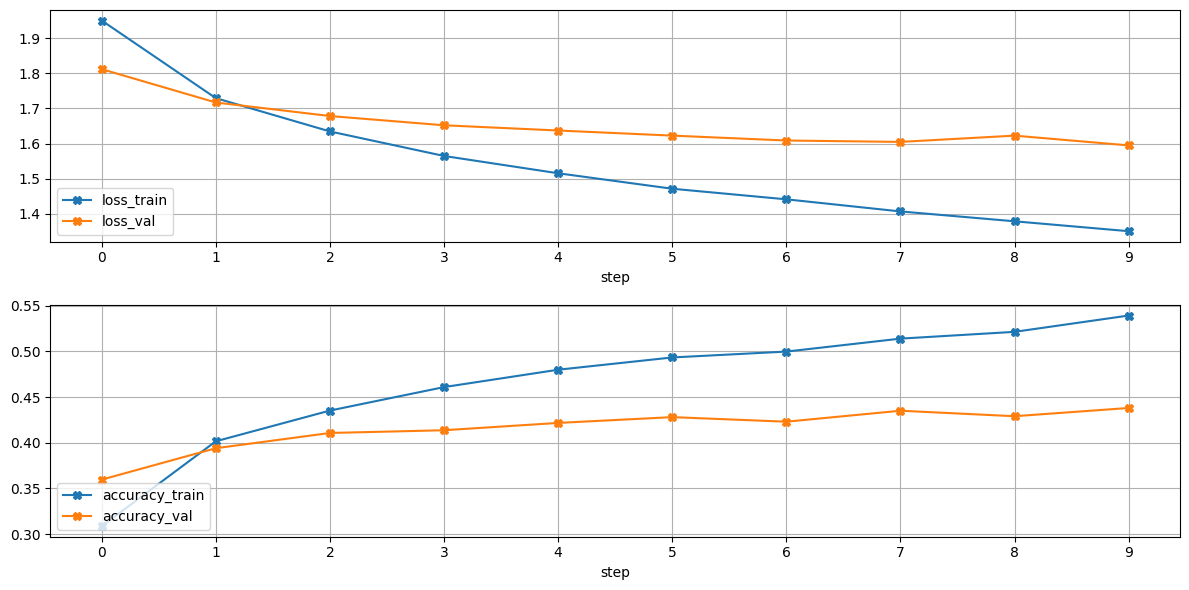

In [ ]:
print('ReLU')
model2 = FCNet(mas_func[2])  # Create model instance
model2.train()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model2, criterion, optimizer, num_epochs=10)
mas_pp.append(pp)

In [ ]:
test_accuracy, _ = calaculate_accuracy(model0.eval(), test_loader,criterion)
print(f"Accuracy on TEST Sigmoid {test_accuracy:.2f}")
test_accuracy, _ = calaculate_accuracy(model1.eval(), test_loader,criterion)
print(f"Accuracy on TEST GELU {test_accuracy:.2f}")
test_accuracy, _ = calaculate_accuracy(model2.eval(), test_loader,criterion)
print(f"Accuracy on TEST ReLU {test_accuracy:.2f}")

Accuracy on TEST Sigmoid 0.39
Accuracy on TEST GELU 0.45
Accuracy on TEST ReLU 0.45


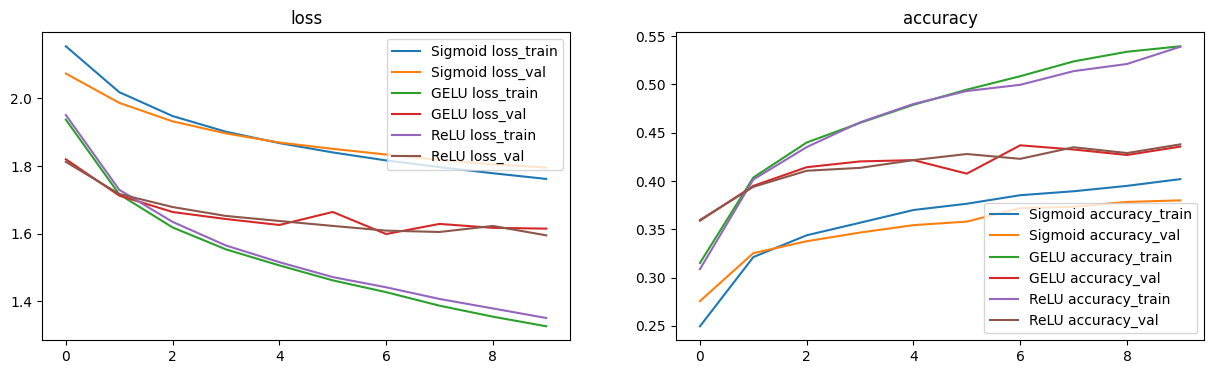

In [ ]:
def plot_train_results(pps_list, plot_request, ax):
  name = ['Sigmoid', 'GELU', 'ReLU']
  for i, d in enumerate(pps_list):
    n = len(d.history_dict[plot_request + '_'+'train'])
    ax.plot( list(range(n)), d.history_dict[plot_request + '_' + 'train'],
              label = name[i] + ' ' + plot_request   + '_' + 'train')
    ax.plot( list(range(n)), d.history_dict[plot_request + '_' + 'val'],
              label = name[i] + ' ' + plot_request   + '_' + 'val')
  ax.set_title(plot_request)
  ax.legend()

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(4)
f.set_figwidth(15)
plot_train_results(mas_pp, 'loss', ax1)
plot_train_results(mas_pp, 'accuracy', ax2)

## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX05/result_3_task_ex05.png" width="600">

# Задание 4. Реализация ReLU

* Самостоятельно реализуйте функцию активации ReLU. (Методами torch)
* Замените в уже обученной модели функцию активации на вашу.

Убедитесь, что точность обученной модели не изменилась.




In [16]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(torch.tensor(0),x)

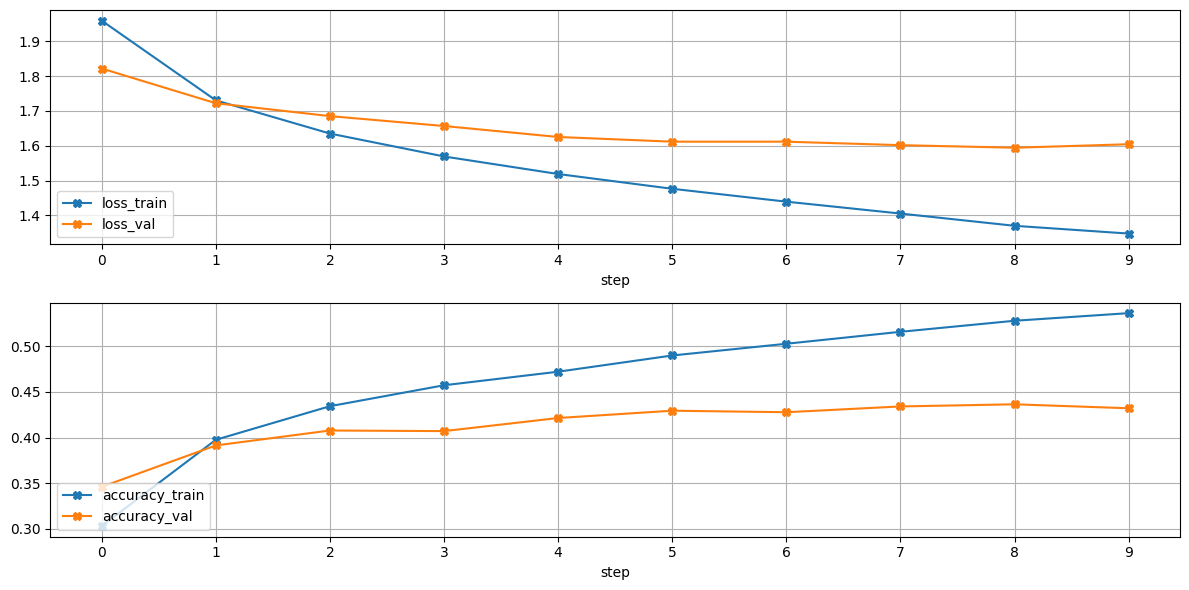

In [ ]:
model3 = FCNet(CustomReLU())  # Create model instance
model3.train()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model3, criterion, optimizer, num_epochs=10)

In [ ]:
test_accuracy, _ = calaculate_accuracy(model3.eval(), test_loader,criterion)
print(f"Accuracy on TEST CustomReLU {test_accuracy:.2f}")

Accuracy on TEST CustomReLU 0.46


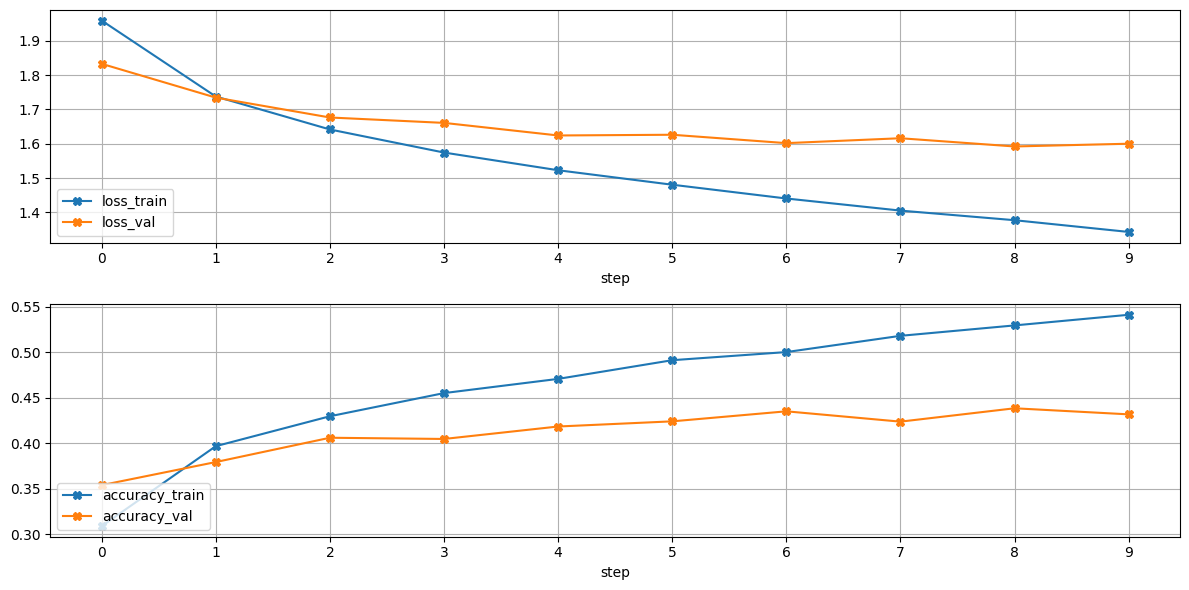

Максимальное значение accuracy на валидационном датасете 0.44


In [18]:
model3 = FCNet(CustomReLU())  # Create model instance
model3.train()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = ProgressPlotter()
pred_acc = 0
for epoch in range(10):
    correct, total, ep_loss = 0, 0, 0
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model3(imgs)
        loss = criterion(outputs, labels)
        correct += get_correct_count(outputs,labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        ep_loss += loss.item()
    # Logging
    pp.add_scalar('loss_train', ep_loss / len(train_loader))
    pp.add_scalar('accuracy_train', correct/total)
    accuracy, loss_val = calaculate_accuracy(model3,val_loader,criterion)
    pp.add_scalar('loss_val',loss_val)
    pp.add_scalar('accuracy_val',accuracy)
    pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    if accuracy > pred_acc:
      pred_acc = accuracy
print(f"Максимальное значение accuracy на валидационном датасете {pred_acc:.2f}")

## Формат результата
Выведите максимальное значение `accuracy` на валидационном датасете для сети со своей реализацией ReLU

# Задание 5. Классифицируйте CIFAR10 с максимальной точностью

Для этого:

*  Стандартизируйте данные
*  Подберите шаг обучения
*  Используйте весь датасет для обучения
*  При необходимости можете добавить в модель еще один скрытый слой


In [ ]:
tensor1 = torch.tensor(dataset.data).permute(dims = (3,1,2,0))
mean = []
std = []
for val in tensor1:
  mean.append(torch.mean(val.double())/255)
  std.append(torch.std(val.double())/255)

tensor1_norm = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean), (std))])
dataset.transform = tensor1_norm
testset.transform = tensor1_norm

trainset, valset = random_split(dataset, [45000,5000])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Оцените точность на тестовом датасете

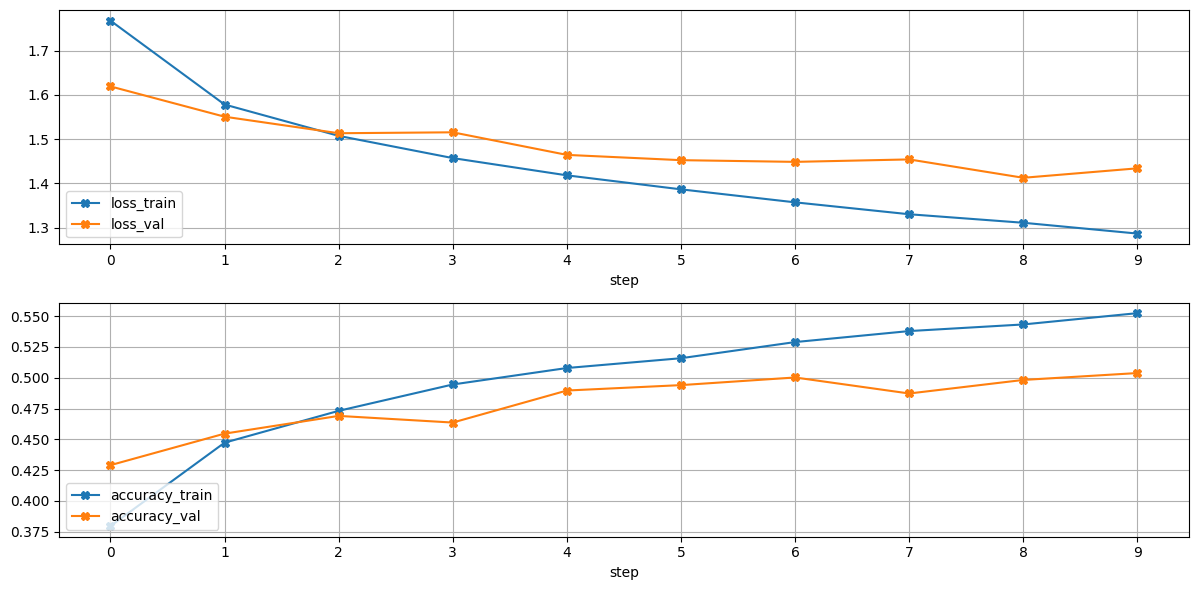

In [ ]:
model4 = FCNet(nn.ReLU())  # Create model instance
model4.train()
optimizer = torch.optim.SGD(model4.parameters(), lr=0.05)  # Weight update
criterion = nn.CrossEntropyLoss() # Loss function
pp = train(model4, criterion, optimizer, num_epochs=10)

In [ ]:
test_accuracy, _ = calaculate_accuracy(model4.eval(), test_loader,criterion)
print(f"Accuracy on TEST CustomReLU {test_accuracy:.2f}")

Accuracy on TEST CustomReLU 0.49


## Формат результата

Выведите графики как в первом задании. Вы должны получить точность 0.48 .. 0.54